In [103]:
import latticeproteins as lp
# need to use myenv2 python -m ipykernel install --user --name myenv --display-name "Python (myenv)"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from copy import deepcopy
from matplotlib.backends.backend_pdf import PdfPages



## Codon tables

In [30]:
codon_to_aa = {"UUU":"F", "UUC":"F", "UUA":"L", "UUG":"L",
    "UCU":"S", "UCC":"S", "UCA":"S", "UCG":"S",
    "UAU":"Y", "UAC":"Y", "UAA":"STOP", "UAG":"STOP",
    "UGU":"C", "UGC":"C", "UGA":"STOP", "UGG":"W",
    "CUU":"L", "CUC":"L", "CUA":"L", "CUG":"L",
    "CCU":"P", "CCC":"P", "CCA":"P", "CCG":"P",
    "CAU":"H", "CAC":"H", "CAA":"Q", "CAG":"Q",
    "CGU":"R", "CGC":"R", "CGA":"R", "CGG":"R",
    "AUU":"I", "AUC":"I", "AUA":"I", "AUG":"M",
    "ACU":"T", "ACC":"T", "ACA":"T", "ACG":"T",
    "AAU":"N", "AAC":"N", "AAA":"K", "AAG":"K",
    "AGU":"S", "AGC":"S", "AGA":"R", "AGG":"R",
    "GUU":"V", "GUC":"V", "GUA":"V", "GUG":"V",
    "GCU":"A", "GCC":"A", "GCA":"A", "GCG":"A",
    "GAU":"D", "GAC":"D", "GAA":"E", "GAG":"E",
    "GGU":"G", "GGC":"G", "GGA":"G", "GGG":"G",}

In [31]:
aa_to_codons = defaultdict(lambda: [])
for c in codon_to_aa:
    aa_to_codons[codon_to_aa[c]].append(c)
aa_to_codons

defaultdict(<function __main__.<lambda>()>,
            {'F': ['UUU', 'UUC'],
             'L': ['UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG'],
             'S': ['UCU', 'UCC', 'UCA', 'UCG', 'AGU', 'AGC'],
             'Y': ['UAU', 'UAC'],
             'STOP': ['UAA', 'UAG', 'UGA'],
             'C': ['UGU', 'UGC'],
             'W': ['UGG'],
             'P': ['CCU', 'CCC', 'CCA', 'CCG'],
             'H': ['CAU', 'CAC'],
             'Q': ['CAA', 'CAG'],
             'R': ['CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
             'I': ['AUU', 'AUC', 'AUA'],
             'M': ['AUG'],
             'T': ['ACU', 'ACC', 'ACA', 'ACG'],
             'N': ['AAU', 'AAC'],
             'K': ['AAA', 'AAG'],
             'V': ['GUU', 'GUC', 'GUA', 'GUG'],
             'A': ['GCU', 'GCC', 'GCA', 'GCG'],
             'D': ['GAU', 'GAC'],
             'E': ['GAA', 'GAG'],
             'G': ['GGU', 'GGC', 'GGA', 'GGG']})

## Make mutations

In [138]:
# get DNA sequence from the initializing sequence (random)
# make 1000 mutations at the DNA level
# figure out how many would be accepted/rejected and calculate dN/dS from the accepted mutations
# take one randomly from that 1000
# keep going

In [32]:
def mutate_codon(codon):
    codon = list(codon)
    pos = np.random.choice([0,1,2])
    bases = ['A', 'C', 'U', 'G']
    bases.remove(codon[pos])
    codon[pos] = np.random.choice(bases)
    return(''.join(codon))

In [372]:
mutate_codon("AUG")

'AGG'

In [241]:
seq_length = 20
temperature = 1.0
lattice = lp.LatticeThermodynamics.from_length(seq_length, 1.0)

In [378]:
# can we make proteins with a frac fold of 0.7 by iteratively mutating?
# yes -- this only takes 6-8 iterations
seq = lp.random_sequence(seq_length)
fracfold = lattice.fracfolded(seq)
iterations = 0
while fracfold < 0.7:
    iterations += 1
    candidates = lp.sequences.n_mutants(seq, 1, 100)  # consider 100 proteins
    candidates_frac = [lattice.fracfolded(x) for x in candidates]
    max_index = np.argmax(candidates_frac)
    seq = candidates[max_index]
    fracfold = candidates_frac[max_index]
print(iterations)
print(seq)

2
['C', 'P', 'I', 'E', 'D', 'F', 'L', 'M', 'A', 'M', 'D', 'M', 'G', 'P', 'W', 'I', 'A', 'S', 'F', 'R']


In [379]:
fitness = lattice.fracfolded(seq)
fitness

0.7165169879064518

In [380]:
seq_mrna = [np.random.choice(aa_to_codons[c]) for c in seq]
seq_mrna

['UGU',
 'CCC',
 'AUC',
 'GAA',
 'GAU',
 'UUU',
 'CUA',
 'AUG',
 'GCU',
 'AUG',
 'GAC',
 'AUG',
 'GGC',
 'CCG',
 'UGG',
 'AUU',
 'GCG',
 'AGU',
 'UUU',
 'CGC']

In [486]:
def make_mutation(seq_mrna, fitness, n=20, T=1/40):
    num_accepted = 0
    new_fitness = 0
    new_seq_mrna = seq_mrna
    
    i = 0
    while i <= n:
        i += 1
        candidate_seq_mrna = deepcopy(seq_mrna)
        
        # choose one codon to make the mutation
        pos = np.random.choice(range(len(seq_mrna)))
        new_codon = mutate_codon(seq_mrna[pos])

        if codon_to_aa[new_codon] == codon_to_aa[seq_mrna[pos]]:  # synonymous
            candidate_seq_mrna[pos] = new_codon
            num_accepted += 1
            
            new_seq_mrna = candidate_seq_mrna
            new_fitness = fitness
        else:  # nonsynonymous
            if codon_to_aa[new_codon] == 'STOP': 
                i -= 1
                continue
                
            candidate_seq_mrna[pos] = new_codon
            new_seq_pro = [codon_to_aa[c] for c in candidate_seq_mrna]
            candidate_fitness = lattice.fracfolded(new_seq_pro)

            # accept the new mutation only if it is within the fitness range
            #if candidate_fitness >= fitness_range[0] and candidate_fitness <= fitness_range[1]:  # accept

            prob = np.random.random()
            fitness_drop = np.exp(fitness) - np.exp(candidate_fitness)
            if candidate_fitness >= fitness or prob < np.exp(-fitness_drop/T):
                num_accepted += 1
                new_seq_mrna = candidate_seq_mrna
                new_fitness = candidate_fitness
            else:
                i -= 1
    
    
    # randomly choose the last one as the mutation to go upon
    return((new_seq_mrna, new_fitness, num_accepted/float(n)))  


In [490]:
def get_trajectory(seq_mrna, fitness_range=0.02, ts=100, n, T):
    fitness = lattice.fracfolded([codon_to_aa[c] for c in seq_mrna])
    fr = [fitness - fitness_range, fitness + fitness_range]
    
    new_seq_mrna = deepcopy(seq_mrna)
    fitness_list = [fitness]
    new_seq_mrna_list = [new_seq_mrna]
    
    df = pd.DataFrame(columns = ["ts", "seq", "fitness"])
    for i in range(ts):
        new_seq_mrna, fitness, pct_accepted = make_mutation(new_seq_mrna, fitness, n, T)
        new_seq_mrna_list.append(new_seq_mrna)
        fitness_list.append(fitness)
        df = df.append({"ts": i, 
                        "seq": ''.join([codon_to_aa[c] for c in new_seq_mrna]), 
                        "fitness": fitness},
                      ignore_index=True)
    return(df)

In [499]:
for inv_t in [20, 40, 60, 70, 80, 90, 100, 120, 140, 200]:
    for i in range(30):
        print("{}_{}... ".format(inv_t, i), end="", flush=True)
        df = get_trajectory(seq_mrna, ts=300, n=1, T=1/inv_t)
        df.to_csv("../data/adaptive_trajectories/traj_{}_{}.csv".format(inv_t, i))

20_0... 20_1... 20_2... 20_3... 20_4... 20_5... 20_6... 20_7... 20_8... 20_9... 20_10... 20_11... 20_12... 20_13... 20_14... 20_15... 20_16... 20_17... 20_18... 20_19... 20_20... 20_21... 20_22... 20_23... 20_24... 20_25... 20_26... 20_27... 20_28... 20_29... 40_0... 40_1... 40_2... 40_3... 40_4... 40_5... 40_6... 40_7... 40_8... 40_9... 40_10... 40_11... 40_12... 40_13... 40_14... 40_15... 40_16... 40_17... 40_18... 40_19... 40_20... 40_21... 40_22... 40_23... 40_24... 40_25... 40_26... 40_27... 40_28... 40_29... 60_0... 60_1... 60_2... 60_3... 60_4... 60_5... 60_6... 60_7... 60_8... 60_9... 60_10... 60_11... 60_12... 60_13... 60_14... 60_15... 60_16... 60_17... 60_18... 60_19... 60_20... 60_21... 60_22... 60_23... 60_24... 60_25... 60_26... 60_27... 60_28... 60_29... 70_0... 70_1... 70_2... 70_3... 70_4... 70_5... 70_6... 70_7... 70_8... 70_9... 70_10... 70_11... 70_12... 70_13... 70_14... 70_15... 70_16... 70_17... 70_18... 70_19... 70_20... 70_21... 70_22... 70_23... 70_24... 70_25

In [478]:
trajectory = pd.read_csv("../data/six_trajectory.txt", sep='\t', header=None)
trajectory.columns = ["timestep", "seq", "fitness"]
trajectory.head()

,timestep,seq,fitness
0,0,CPIEDFLMAMDMGPWIASFR,0.716517
1,1,CPIEDFLMAMNMGPWIASFR,0.713354
2,2,CPIEDFLMAMNMGPWIASFR,0.713354
3,3,CPIKDFLMAMNMGPWIASFR,0.737721
4,4,CPIKDFLMAMNMGPWIASFR,0.737721


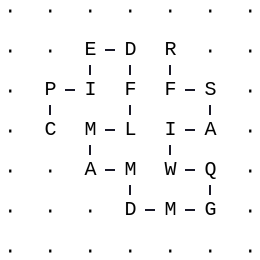

In [385]:
seq = ['C', 'P', 'I', 'E', 'D', 'F', 'L', 'M', 'A', 'M', 'D', 'M', 'G', 'P', 'W', 'I', 'A', 'S', 'F', 'R']
conf = lattice.native_conf(seq)
lp.draw.in_notebook(seq, conf)

In [387]:
# for the first protein, one_trajectory
# position_to_contacts = {
#     1: [8, 20, 14, 7, 3, 13, 17],
#     2: [5, 7, 6, 4, 8, 20],
#     3: [20, 1, 19, 5],
#     4: [2],
#     5: [7, 3, 2],
#     6: [2],
#     7: [2, 5, 1],
#     8: [1, 13, 2, 14, 10],
#     9: [13],
#     10: [13, 8, 12],
#     11: [13],
#     12: [15, 10, 14],
#     13: [8, 10, 9, 1, 11, 15],
#     14: [1, 17, 8, 20, 12, 16],
#     15: [12, 13, 17],
#     16: [14, 18],
#     17: [14, 20, 1, 19, 15],
#     18: [20, 16],
#     19: [17],
#     20: [1, 17, 3, 2, 18, 14]
# }

# for the second protein
position_to_contacts = {
    1: [3, 8, 9],
    2: [4, 8],
    3: [5, 6, 7, 1],
    4: [6, 2],
    5: [3, 20, 19],
    6: [4, 20, 19, 8, 16],
    7: [3, 19, 16, 15, 9, 10],
    8: [2, 3, 6, 10],
    9: [1, 7, 11],
    10: [8, 16, 15, 12],
    11: [9, 15],
    12: [10, 15, 14],
    13: [15],
    14: [17, 16, 12],
    15: [7, 17, 10, 11, 12, 13],
    16: [6, 19, 18, 7, 10, 14],
    17: [19, 14, 15],
    18: [16, 20],
    19: [5, 6, 7, 16, 17],
    20: [5, 6, 18]
}

In [441]:
# zero-indexed
for i in range(20):
    position_to_contacts[i] = [x-1 for x in position_to_contacts[i+1]]
position_to_contacts

{1: [3, 4, 5, -1],
 2: [4, 0],
 3: [1, 18, 17],
 4: [2, 18, 17, 6, 14],
 5: [1, 17, 14, 13, 7, 8],
 6: [0, 1, 4, 8],
 7: [-1, 5, 9],
 8: [6, 14, 13, 10],
 9: [7, 13],
 10: [8, 13, 12],
 11: [13],
 12: [15, 14, 10],
 13: [5, 15, 8, 9, 10, 11],
 14: [4, 17, 16, 5, 8, 12],
 15: [17, 12, 13],
 16: [14, 18],
 17: [3, 4, 5, 14, 15],
 18: [3, 4, 16],
 19: [4, 5, 17],
 20: [5, 6, 18],
 0: [2, 6]}

In [479]:
# at every step which position changed?
position_at_step = []
for ts in range(1, trajectory.shape[0]):
    old_seq = list(str(trajectory.loc[ts-1]["seq"]))
    new_seq = list(str(trajectory.loc[ts]["seq"]))
    
    for pos in range(len(new_seq)):
        if old_seq[pos] != new_seq[pos]:
            fitness_change = trajectory.loc[ts]["fitness"] - trajectory.loc[ts-1]["fitness"]
            position_at_step.append([pos, ts, old_seq[pos], new_seq[pos], fitness_change])

In [463]:
position_at_step

[[4, 4, 'D', 'E', -0.003968509240105389],
 [10, 5, 'D', 'E', -0.003646151504372752],
 [10, 6, 'E', 'D', 0.003646151504372752],
 [13, 8, 'P', 'Q', 0.010505302450963261],
 [8, 11, 'A', 'S', 0.05327760408364923],
 [7, 12, 'M', 'I', 0.001125048367212167],
 [11, 13, 'M', 'L', -0.0003522723976283615],
 [2, 15, 'I', 'F', 0.007719784396621021],
 [7, 21, 'I', 'M', 0.005674216119350928],
 [12, 23, 'G', 'R', 0.005752411560895787],
 [11, 26, 'L', 'V', 0.007794130650041753],
 [12, 27, 'R', 'S', -0.0007937641469522028],
 [11, 28, 'V', 'L', -0.007667769527596735],
 [15, 30, 'I', 'F', -0.004861292367368875],
 [11, 31, 'L', 'V', 0.009214464361830266],
 [16, 33, 'A', 'S', 0.008919083794520999],
 [16, 35, 'S', 'Y', 0.008790313821268825],
 [13, 36, 'Q', 'P', -0.0025872726819726743],
 [17, 37, 'S', 'R', -0.0016995642169828074],
 [17, 38, 'R', 'S', 0.0016995642169828074],
 [4, 48, 'E', 'D', 0.002701423934493574],
 [17, 51, 'S', 'N', 0.0021645570570762995],
 [12, 52, 'S', 'R', 0.00030277398277600565],
 [4, 5

In [480]:
# what is the probability that the 5 beneficial (>0.01) mutations 
# after every step are in the neighborhood of the initial mutation?

df = pd.DataFrame(columns=["pos", "obs", "exp", "step", "fitness"])
for i in range(len(position_at_step)):
    mut = position_at_step[i]
    pos = mut[0]
    
    # if position has no contacts, continue
    if len(position_to_contacts[pos]) == 0: continue
    
    # get subsequent beneficial mutations
    subsequent_beneficial_muts = []
    j = 0
    while len(subsequent_beneficial_muts) < 5:
        j += 1
        if i + j >= len(position_at_step): break  # end of protein
        #if position_at_step[i + j][-1] <0:  # beneficial
        subsequent_beneficial_muts.append(position_at_step[i + j][0])
    
    obs = len([x for x in subsequent_beneficial_muts if x in position_to_contacts[pos]])
    exp = len(position_to_contacts[pos])  # zero indexed vs one indexed
    
    df = df.append({"pos": pos, "obs": obs, "exp": exp, "step": mut[1], "fitness": mut[-1]}, 
                   ignore_index=True)
print(sum(df["obs"]))
print(sum(df["exp"])*5/19)
df

61.0
90.78947368421052


,pos,obs,exp,step,fitness
0,10.0,1.0,3.0,1.0,-0.003163
1,3.0,1.0,3.0,3.0,0.024367
2,12.0,1.0,3.0,8.0,0.004213
3,10.0,2.0,3.0,9.0,0.002624
4,11.0,0.0,1.0,11.0,0.000755
5,17.0,0.0,5.0,15.0,0.004941
6,12.0,1.0,3.0,17.0,0.005241
7,16.0,0.0,2.0,19.0,0.000261
8,8.0,2.0,4.0,20.0,0.048398
9,10.0,1.0,3.0,21.0,-0.002441


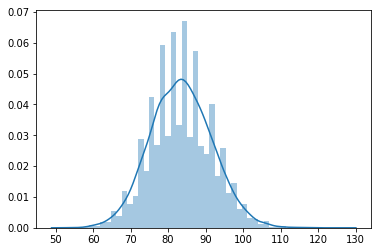

In [481]:
# modeling the distribution you should expect

sums = [0] * 10000
for i in range(len(position_at_step)-10):
    pos = position_at_step[i][0]
    num_contacts = len(position_to_contacts[pos])
    
    for j in range(10000):
        sums[j] += np.random.binomial(5, num_contacts/19)
    
sns.distplot(sums)

In [474]:
np.percentile(sums, 70)

128.0

In [482]:
# are large beneficial mutations driven by prior mutations in contacts?

num_beneficial = 0
mutations_in_contacts = 0
for i in range(len(position_at_step)):
    mut = position_at_step[i]
    if mut[-1] < 0.005: continue  # not beneficial enough 
    num_beneficial += 1
    
    pos = mut[0]
    contacts = position_to_contacts[pos]
    
    for j in range(1,6):
        if i - j < 0: break
        if position_at_step[i - j][0] in contacts:
            mutations_in_contacts += 1
            break
            
print(num_beneficial, mutations_in_contacts)

15 6


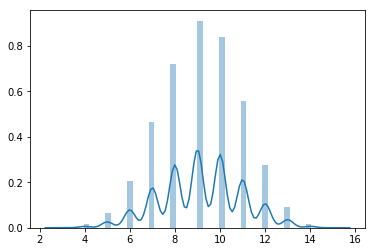

In [483]:
# are large beneficial mutations driven by mutations in contacts?

sums = [0] * 10000
for i in range(len(position_at_step)):
    mut = position_at_step[i]
    if mut[-1] < 0.005: continue  # not beneficial enough 
    num_beneficial += 1
    
    pos = mut[0]
    num_contacts = len(position_to_contacts[pos])
    
    for j in range(10000):
        if np.random.binomial(5, num_contacts/19) > 0:
            sums[j] += 1
            
sns.distplot(sums)

In [471]:
np.percentile(sums, 1)

10.0

In [ ]:
# what is the distance between pairs of mutations (in time steps)?


In [169]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('../data/181203_from_0_7.pdf')

Text(0, 0.5, 'Fitness')

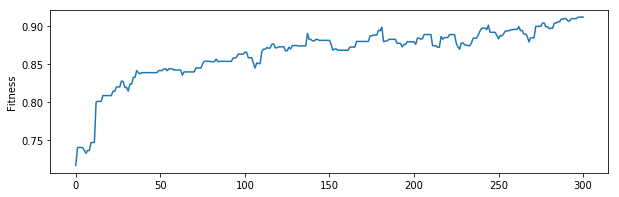

In [459]:
plt.figure(figsize=[10,3])
sns.lineplot(x=range(301), y=fitness_list)
plt.ylabel("Fitness")
#pp.savefig()

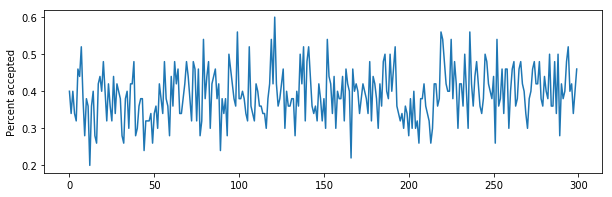

In [171]:
plt.figure(figsize=[10,3])
sns.lineplot(x=range(300), y=pct_accepted_list)
plt.ylabel("Percent accepted")
pp.savefig()

In [172]:
pp.close()

In [403]:
new_seq_aa_list = [[codon_to_aa[x] for x in seq] for seq in new_seq_mrna_list]
new_seq_aa_list

[['C',
  'P',
  'I',
  'E',
  'D',
  'F',
  'L',
  'M',
  'A',
  'M',
  'D',
  'M',
  'G',
  'P',
  'W',
  'I',
  'A',
  'S',
  'F',
  'R'],
 ['C',
  'P',
  'I',
  'E',
  'D',
  'F',
  'L',
  'M',
  'A',
  'M',
  'D',
  'M',
  'G',
  'Q',
  'W',
  'I',
  'A',
  'S',
  'F',
  'R'],
 ['C',
  'P',
  'I',
  'E',
  'D',
  'F',
  'I',
  'M',
  'A',
  'M',
  'D',
  'M',
  'G',
  'Q',
  'W',
  'I',
  'A',
  'S',
  'F',
  'R'],
 ['C',
  'P',
  'I',
  'E',
  'D',
  'F',
  'I',
  'M',
  'A',
  'M',
  'D',
  'M',
  'G',
  'Q',
  'W',
  'I',
  'A',
  'S',
  'F',
  'R'],
 ['C',
  'P',
  'I',
  'E',
  'D',
  'F',
  'I',
  'M',
  'A',
  'M',
  'D',
  'M',
  'G',
  'Q',
  'W',
  'I',
  'A',
  'N',
  'F',
  'R'],
 ['C',
  'P',
  'I',
  'E',
  'D',
  'F',
  'I',
  'M',
  'A',
  'M',
  'D',
  'M',
  'G',
  'Q',
  'W',
  'I',
  'A',
  'S',
  'F',
  'R'],
 ['C',
  'P',
  'I',
  'E',
  'D',
  'F',
  'I',
  'M',
  'A',
  'M',
  'D',
  'M',
  'G',
  'Q',
  'W',
  'I',
  'A',
  'S',
  'F',
  'R'],
 ['C',
  'P',

In [404]:
def codon_diversity(pos):
    codons = set()
    div = []
    for seq in new_seq_aa_list:
        codons.add(seq[pos])
        div.append(len(codons))
    return(div)

In [75]:
len(codon_diversity(0))

301

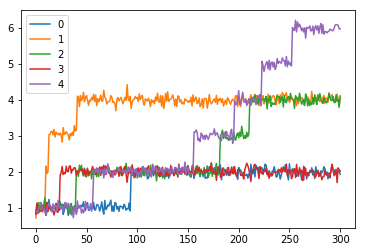

In [405]:
for i in range(5):
    sns.lineplot(x=range(301), y=[x + np.random.normal(scale=0.1) for x in codon_diversity(i)], label=i)
plt.legend()

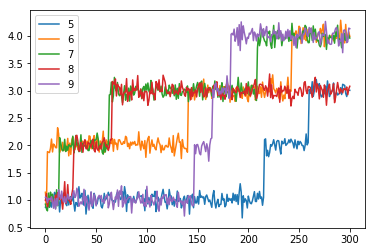

In [406]:
for i in range(5,10):
    sns.lineplot(x=range(301), y=[x + np.random.normal(scale=0.1) for x in codon_diversity(i)], label=i)
plt.legend()

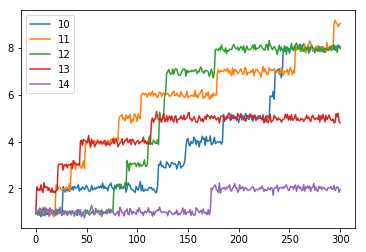

In [407]:
for i in range(10,15):
    sns.lineplot(x=range(301), y=[x + np.random.normal(scale=0.1) for x in codon_diversity(i)], label=i)
plt.legend()

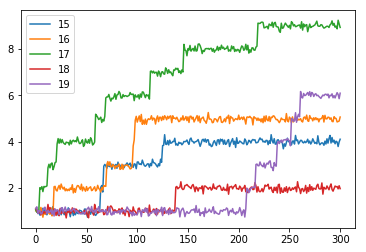

In [408]:
for i in range(15,20):
    sns.lineplot(x=range(301), y=[x + np.random.normal(scale=0.1) for x in codon_diversity(i)], label=i)
plt.legend()

In [179]:
# at every step which position changed?
position_at_step = []
for ts in range(1,len(new_seq_aa_list)):
    old_seq = new_seq_aa_list[ts-1]
    new_seq = new_seq_aa_list[ts]
    
    for pos in range(len(new_seq)):
        if old_seq[pos] != new_seq[pos]:
            position_at_step.append(pos)

([<matplotlib.axis.XTick at 0x1a1fbbe048>,
 <a list of 20 Text xticklabel objects>)

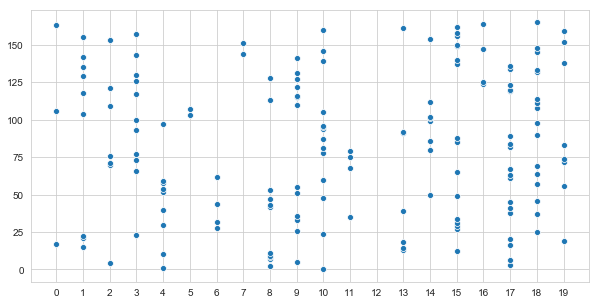

In [180]:
plt.figure(figsize=[10,5])
sns.set_style(style="whitegrid")
sns.scatterplot(y=range(len(position_at_step)), x=position_at_step)
plt.xticks(range(20))

In [185]:
import pickle
with open("../data/181203_trajs.pkl", 'wb') as fp:
    pickle.dump((new_seq_mrna, fitness_list, pct_accepted_list, dN_dS_list, new_seq_mrna_list), fp)

## See how many possible evolutionary trajectories there are

* generate a source protein
* generate a target protein by mutating it 6 or 7 mutations towards a better fitness for the same structure (same as Sailer et al.)
* Enumerate energies for all combinations of mutations
     * can use different models of epistasis, or just use the energy model in the package
* Calculate possible trajectories using energy


- try this with different energies (a super well folded protein, a not so well folded one)
- caveat: lattice models might be using pairwise epistasis so this may be cyclical logic
- another caveat: these may not be the only evolutionary trajectories to increase fitness

In [2]:
seq_length = 20
temperature = 1.0
lattice = lp.LatticeThermodynamics.from_length(seq_length, 1.0)

In [144]:
# can we make proteins with a frac fold of 0.7 by iteratively mutating?
# yes -- this only takes 6-8 iterations
seq = lp.random_sequence(seq_length)
fracfold = lattice.fracfolded(seq)
iterations = 0
while fracfold < 0.6:
    iterations += 1
    candidates = lp.sequences.n_mutants(seq, 1, 20)  # consider 20 proteins
    candidates_frac = [lattice.fracfolded(x) for x in candidates]
    max_index = np.argmax(candidates_frac)
    seq = candidates[max_index]
    fracfold = candidates_frac[max_index]
print(iterations)
print(seq)

15
['Y', 'C', 'R', 'I', 'C', 'N', 'H', 'K', 'E', 'W', 'F', 'R', 'V', 'I', 'I', 'D', 'D', 'S', 'L', 'S']


In [145]:
fitness = lattice.fracfolded(seq)
fitness

0.6136421291484817

In [146]:
lattice.nativeE(seq)

-52.129999999999995

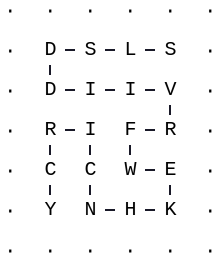

In [147]:
conf = lattice.native_conf(seq)
lp.draw.in_notebook(seq, conf)

In [148]:
# accepts mutations according to decreasing energy not fitness
# we could do this by fitness

def make_mutation_by_fitness(seq_mrna, fitness, conf):
    new_fitness = 0
    new_seq_mrna = seq_mrna
    
    mutation = [0, ""]

    while True:         
        candidate_seq_mrna = deepcopy(seq_mrna)
        
        # choose one codon to make the mutation
        pos = np.random.choice(range(len(seq_mrna)))
        new_codon = mutate_codon(seq_mrna[pos])

        old_aa = codon_to_aa[seq_mrna[pos]]
        new_aa = codon_to_aa[new_codon]
        if new_aa != old_aa:  # nonsynonymous
            if new_aa == 'STOP': continue
        
            candidate_seq_mrna[pos] = new_codon
            new_seq_pro = [codon_to_aa[c] for c in candidate_seq_mrna]
            candidate_fitness = lattice.fracfolded(new_seq_pro)

            if candidate_fitness > fitness:  # only take improved energy
                new_seq_mrna = candidate_seq_mrna
                new_fitness = candidate_fitness
                mutation = [pos, ''.join([old_aa, new_aa])]
                return((new_seq_mrna, new_fitness, mutation)) 
            
def make_mutation_by_energy(seq_mrna, energy, conf):
    num_accepted = 0
    new_energy = 0
    new_seq_mrna = seq_mrna
    
    mutation = [0, ""]

    while True:         
        candidate_seq_mrna = deepcopy(seq_mrna)
        
        # choose one codon to make the mutation
        pos = np.random.choice(range(len(seq_mrna)))
        new_codon = mutate_codon(seq_mrna[pos])

        old_aa = codon_to_aa[seq_mrna[pos]]
        new_aa = codon_to_aa[new_codon]
        if new_aa != old_aa:  # nonsynonymous
            if new_aa == 'STOP': continue
        
            candidate_seq_mrna[pos] = new_codon
            new_seq_pro = [codon_to_aa[c] for c in candidate_seq_mrna]
            candidate_energy = lattice.nativeE(new_seq_pro, target=conf)

            if candidate_energy < energy:  # only take improved energy
                new_seq_mrna = candidate_seq_mrna
                new_energy = candidate_energy
                mutation = [pos, ''.join([old_aa, new_aa])]
                return((new_seq_mrna, new_energy, mutation))  

In [71]:
# test this out
energy = lattice.nativeE(seq)
conf = lattice.native_conf(seq)
fitness = lattice.fracfolded(seq)
seq_mrna = [np.random.choice(aa_to_codons[c]) for c in seq]
#make_mutation_by_energy(seq_mrna, energy, conf)
make_mutation_by_fitness(seq_mrna, fitness, conf)

(['UAC',
  'AAC',
  'CAU',
  'CGC',
  'GUU',
  'CUU',
  'AAA',
  'GGA',
  'AUC',
  'GAA',
  'AUG',
  'AUG',
  'CUC',
  'ACA',
  'GAG',
  'AAU',
  'GAG',
  'AUG',
  'AUA',
  'UAU'],
 0.6937266821234406,
 [15, 'DN'])

In [149]:
fitness = lattice.fracfolded(seq, target=conf)
fitness

0.6136421291484817

In [72]:
# Now I want to mutate this thing 7 times with increasing energy
def get_trajectory_by_energy(seq_mrna, ts=7):
    energy = lattice.nativeE(seq)
    conf = lattice.native_conf(seq)
    mutations = []
    energies = [energy]
    sequences = [[codon_to_aa[c] for c in seq_mrna]]
    
    for i in range(ts):
        seq_mrna, energy, mutation = make_mutation_by_energy(seq_mrna, energy, conf)
        mutations.append(mutation)
        energies.append(energy)
        sequences.append([codon_to_aa[c] for c in seq_mrna])
        
    return(mutations, energies, sequences)

# by fitness
def get_trajectory_by_fitness(seq_mrna, ts=7):
    fitness = lattice.fracfolded(seq)
    conf = lattice.native_conf(seq)
    mutations = []
    fitnesses = [fitness]
    sequences = [[codon_to_aa[c] for c in seq_mrna]]
    
    for i in range(ts):
        seq_mrna, fitness, mutation = make_mutation_by_fitness(seq_mrna, fitness, conf)
        mutations.append(mutation)
        fitnesses.append(fitness)
        sequences.append([codon_to_aa[c] for c in seq_mrna])
        
    return(mutations, fitnesses, sequences)

In [73]:
#(mutations, energies, sequences) = get_trajectory_by_energy(seq_mrna)
(mutations, fitnesses, sequences) = get_trajectory_by_fitness(seq_mrna)

In [74]:
mutations

[[7, 'GR'],
 [15, 'DG'],
 [11, 'ML'],
 [10, 'ML'],
 [3, 'RS'],
 [0, 'YF'],
 [14, 'EK']]

In [75]:
fitnesses

[0.6554496896449009,
 0.6667759893078073,
 0.7259151939688939,
 0.7301472002741214,
 0.7541716894253919,
 0.770246662677947,
 0.7731586016626522,
 0.7810935557897778]

In [76]:
[''.join(x) for x in sequences]

['YNHRVLKGIEMMLTEDEMIY',
 'YNHRVLKRIEMMLTEDEMIY',
 'YNHRVLKRIEMMLTEGEMIY',
 'YNHRVLKRIEMLLTEGEMIY',
 'YNHRVLKRIELLLTEGEMIY',
 'YNHSVLKRIELLLTEGEMIY',
 'FNHSVLKRIELLLTEGEMIY',
 'FNHSVLKRIELLLTKGEMIY']

In [79]:
[lattice.nativeE(''.join(x), target=conf) for x in sequences]

[-53.17999999999999,
 -53.17999999999999,
 -54.01999999999999,
 -53.699999999999996,
 -53.39999999999999,
 -53.39999999999999,
 -56.56,
 -56.56]

In [80]:
def apply_mutation(protein, mutation):
    # protein is a list of aa's
    # mutation is a tuple where the first element is the position (0 indexed) 
    # and the second element is the old and new codon
    new_protein = deepcopy(protein)
    new_aa = list(mutation[1])[1]
    new_protein[mutation[0]] = new_aa
    return new_protein

In [81]:
[''.join(apply_mutation(seq, mut)) for mut in mutations]

['YNHRVLKRIEMMLTEDEMIY',
 'YNHRVLKGIEMMLTEGEMIY',
 'YNHRVLKGIEMLLTEDEMIY',
 'YNHRVLKGIELMLTEDEMIY',
 'YNHSVLKGIEMMLTEDEMIY',
 'FNHRVLKGIEMMLTEDEMIY',
 'YNHRVLKGIEMMLTKDEMIY']

In [82]:
[lattice.fracfolded(''.join(apply_mutation(seq, mut))) for mut in mutations]

[0.6667759893078073,
 0.716559148393225,
 0.6582912862626654,
 0.6849677800287515,
 0.6740027213313262,
 0.6941264185771984,
 0.6718202743982515]

In [83]:
sum([lattice.fracfolded(''.join(apply_mutation(seq, mut))) - fitness for mut in mutations])

0.17839579078491896

In [84]:
# now I want to calculate all possible evolutionary trajectories
from itertools import permutations 
trajs = []

initial_protein = sequences[0]
perms = permutations(mutations[:5])

i = 0
for p in perms:
    i += 1
    if i % 50 == 0:
        print("{}... ".format(i), end="", flush=True)
    protein = deepcopy(initial_protein)
    energy = lattice.nativeE(protein, target=conf)

    fitness = lattice.fracfolded(protein)

    trajectory = []
    for mutation in p:
        new_protein = apply_mutation(protein, mutation) 
        #new_energy = lattice.nativeE(new_protein, target=conf)
        #new_energy = lattice.nativeE(new_protein)  # i allow them to fold in their native conf since that improves fitness
        new_fitness = lattice.fracfolded(new_protein)
        delta = new_fitness - fitness
        trajectory.append((mutation, new_fitness, delta))
        
        protein = new_protein
        fitness = new_fitness
    trajs.append(trajectory)

50... 100... 

In [111]:
# if the delta in fitness is proportional to the probability of fixation (p ~ s) then i multiply them all
probabilities = []
for traj in trajs:
    print([round(i[2],3) for i in traj])
    prob = 1
    for j in range(1,len(traj)):
        prob = prob * (1 - np.exp(1-traj[j][1]/traj[j-1][1]))
    probabilities.append(prob)

[0.011, 0.059, 0.004, 0.024, 0.016]
[0.011, 0.059, 0.004, 0.016, 0.024]
[0.011, 0.059, 0.025, 0.004, 0.016]
[0.011, 0.059, 0.025, 0.015, 0.005]
[0.011, 0.059, 0.015, 0.006, 0.024]
[0.011, 0.059, 0.015, 0.024, 0.005]
[0.011, 0.003, 0.06, 0.024, 0.016]
[0.011, 0.003, 0.06, 0.016, 0.024]
[0.011, 0.003, 0.028, 0.056, 0.016]
[0.011, 0.003, 0.028, 0.018, 0.053]
[0.011, 0.003, 0.019, 0.057, 0.024]
[0.011, 0.003, 0.019, 0.028, 0.053]
[0.011, 0.029, 0.055, 0.004, 0.016]
[0.011, 0.029, 0.055, 0.015, 0.005]
[0.011, 0.029, 0.003, 0.056, 0.016]
[0.011, 0.029, 0.003, 0.018, 0.053]
[0.011, 0.029, 0.017, 0.053, 0.005]
[0.011, 0.029, 0.017, 0.004, 0.053]
[0.011, 0.017, 0.057, 0.006, 0.024]
[0.011, 0.017, 0.057, 0.024, 0.005]
[0.011, 0.017, 0.005, 0.057, 0.024]
[0.011, 0.017, 0.005, 0.028, 0.053]
[0.011, 0.017, 0.028, 0.053, 0.005]
[0.011, 0.017, 0.028, 0.004, 0.053]
[0.061, 0.009, 0.004, 0.024, 0.016]
[0.061, 0.009, 0.004, 0.016, 0.024]
[0.061, 0.009, 0.025, 0.004, 0.016]
[0.061, 0.009, 0.025, 0.015, 0

In [112]:
probabilities

[3.3678400735635375e-07,
 3.4224938100045593e-07,
 2.9142270267355526e-07,
 3.6754842172657864e-07,
 4.1829170840290183e-07,
 3.748982514175354e-07,
 2.85993530751028e-07,
 2.906346700902143e-07,
 3.2823141590837536e-07,
 3.773671609004099e-07,
 3.4401200913371887e-07,
 3.885900189204433e-07,
 3.320785959394205e-07,
 4.1882448658584865e-07,
 2.699405703817421e-07,
 3.103502642331805e-07,
 4.840851915670001e-07,
 4.4840133362251843e-07,
 4.9823541201304e-07,
 4.4654861907534824e-07,
 4.7540761042737794e-07,
 5.370122188353281e-07,
 5.01686783710936e-07,
 4.6470544192558807e-07,
 5.1473227699198424e-08,
 5.230854177557735e-08,
 4.454031902874652e-08,
 5.6175184060907463e-08,
 6.393066143585419e-08,
 5.729851369939784e-08,
 4.969971787925852e-08,
 5.0506251213037647e-08,
 4.7456136003921745e-08,
 4.448113185986144e-08,
 4.7357529909848446e-08,
 4.517108560133885e-08,
 4.272126424826048e-08,
 5.3880954038784695e-08,
 4.160500484391932e-08,
 3.8996805520357025e-08,
 5.074844051778251e-08,
 

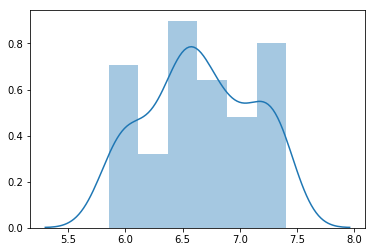

In [114]:
sns.distplot(-np.log10(probabilities))

In [117]:
trajs[np.argmax(probabilities)]

[([11, 'ML'], 0.6582912862626654, 0.002841596617764508),
 ([7, 'GR'], 0.670039817455463, 0.011748531192797618),
 ([3, 'RS'], 0.6892314146034941, 0.019191597148031092),
 ([10, 'ML'], 0.7168251123265598, 0.027593697723065636),
 ([15, 'DG'], 0.770246662677947, 0.05342155035138718)]

In [88]:
f = fitnesses
-np.log10((f[1] - f[0]) * (f[2] - f[1]) * (f[3] - f[2]) * (f[4] - f[3]) * (f[5] - f[4]))

8.960685745941628

In [90]:
np.min(-np.log10(probabilities))

8.814597661160157

Surprisingly (or maybe unsurprisingly) all 7! = 5040 trajectories are accessible (meaning that the energy decreases with each step). Maybe this is unrurprising as the energy model uses pairwise contacts

http://www.pnas.org/content/early/2017/10/20/1711927114#sec-9

# Run lots of evolutionary trajectories

We will start from one protein and then do dN/dS and amino acid usage. We will assume various models of epistasis and see if they match the Breen et al. predictions.

In [122]:
seq_length = 20
temperature = 1.0
lattice = lp.LatticeThermodynamics.from_length(seq_length, 1.0)

In [123]:
# can we make proteins with a frac fold of 0.7 by iteratively mutating?
# yes -- this only takes 6-8 iterations
seq = lp.random_sequence(seq_length)
fracfold = lattice.fracfolded(seq)
iterations = 0
while fracfold < 0.6:
    iterations += 1
    candidates = lp.sequences.n_mutants(seq, 1, 100)  # consider 100 proteins
    candidates_frac = [lattice.fracfolded(x) for x in candidates]
    max_index = np.argmax(candidates_frac)
    seq = candidates[max_index]
    fracfold = candidates_frac[max_index]
print(iterations)
print(seq)

5
['A', 'N', 'S', 'H', 'G', 'K', 'Y', 'L', 'F', 'I', 'E', 'R', 'I', 'L', 'E', 'K', 'V', 'T', 'I', 'K']


In [124]:
lattice.fracfolded(seq)

0.6109757244628693

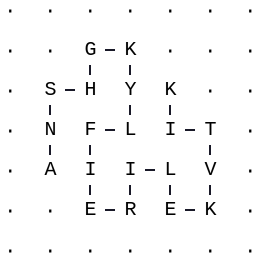

In [132]:
conf = lattice.native_conf(seq)
seq_mrna = [np.random.choice(aa_to_codons[c]) for c in seq]
lp.draw.in_notebook(seq, conf)

In [138]:
# first we only accept mutations if they increase the fitness, using the same target configuration
# later we will consider different acceptance probabilities under MH

# by fitness
def get_trajectory_by_fitness_goal(seq_mrna, conf, goal_fitness=0.85):
    fitness = lattice.fracfolded(seq, target=conf)
    mutations = []
    fitnesses = [fitness]
    sequences = [[codon_to_aa[c] for c in seq_mrna]]
    
    repeat = 0
    while fitness < goal_fitness:
        seq_mrna, new_fitness, mutation = make_mutation_by_fitness(seq_mrna, fitness, conf)
        
        if new_fitness > fitness:
            repeat = 0
        else:
            repeat += 1
        if repeat > 5: break
            
        new_seq = [codon_to_aa[c] for c in seq_mrna]
        mutations.append(mutation)
        fitnesses.append(new_fitness)
        fitness = new_fitness
        sequences.append(new_seq)
        print(''.join(new_seq), new_fitness)
        
        new_fitness = fitness
        
    return(mutations, fitnesses, sequences)

In [139]:
mut1 = get_trajectory_by_fitness_goal(seq_mrna, conf)

ATSHGKYLFIERILEKVTIK 0.6233408168499902
ATSHGKYLFIERILEKVSIK 0.6342219597554797
ATSHGKYLFIERILEKVSIN 0.6488294839836196
ATSHGKYLCIERILEKVSIN 0.6785144789478255
ASSHGKYLCIERILEKVSIN 0.6907802478395746
AGSHGKYLCIERILEKVSIN 0.7153162961990761
AGSHRKYLCIERILEKVSIN 0.7425051320227997
AGSHRKYLCIKRILEKVSIN 0.7627594158755461
AGSHPKYLCIKRILEKVSIN 0.7640562881792005
AGRHPKYLCIKRILEKVSIN 0.7717609826820327
AGRHPKFLCIKRILEKVSIN 0.820463178722354
AGRHPKFLCIKRIIEKVSIN 0.8210639935763604
AGRHPKFLCIKRIIEKVSFN 0.8270938210716342
AGRYPKFLCIKRIIEKVSFN 0.8348341810708756
AGRFPKFLCIKRIIEKVSFN 0.9045033277091568


# Analyzing 1,050 evolutionary trajectories

In [132]:
# seq = ['A', 'N', 'S', 'H', 'G', 'K', 'Y', 'L', 'F', 'I', 'E', 'R', 'I', 'L', 'E', 'K', 'V', 'T', 'I', 'K'] # for adaptive
# seq = ['L', 'M', 'L', 'R', 'R', 'K', 'V', 'F', 'D', 'F', 'Q', 'W', 'M', 'W', 'M', 'G', 'F', 'Q', 'K', 'I']  # for purifying
seq = ['G', 'C', 'F', 'C', 'M', 'K', 'C', 'G', 'N', 'G', 'C', 'K', 'F', 'K', 'K', 'F', 'K', 'F', 'K', 'W']  # 0.9
conf = lattice.native_conf(seq)
seq_mrna = [aa_to_codons[c][0] for c in seq]
print(seq_mrna)

['GGU', 'UGU', 'UUU', 'UGU', 'AUG', 'AAA', 'UGU', 'GGU', 'AAU', 'GGU', 'UGU', 'AAA', 'UUU', 'AAA', 'AAA', 'UUU', 'AAA', 'UUU', 'AAA', 'UGG']


In [227]:
# get all my evolutionary trajectories
import glob
all_trajectories = []
#files = glob.glob('../data/trajectories/*.csv') # 1050
#files = glob.glob('../data/trajectories_purifying_09/*.csv')  # 1001
#files = glob.glob('../data/trajectories_purifying_09_001/*.csv')  # 1001
#files = glob.glob('../data/trajectories_purifying_09_0005/*.csv')  # 3001
#files = glob.glob('../data/trajectories_purifying_09_0005_100/*.csv') # 100
#files = glob.glob("../data/trajectories_09_neutral/*.csv")  
# files = glob.glob("../data/trajectories_09_2/*.csv")  
files = glob.glob('../data/trajectories_09_00045/*.csv')

count = 0
for fn in files:    
    count += 1
    if count % 50 == 0:
        print("{}... ".format(count), end="", flush=True)
    df = pd.read_csv(fn)
    traj = []
    for i in range(df.shape[0]):
        traj.append(list(df.loc[i])[1:])
    all_trajectories.append(traj)

50... 100... 150... 200... 250... 300... 350... 400... 450... 500... 550... 600... 650... 700... 750... 800... 850... 900... 950... 

In [228]:
# get final proteins

final_seqs = []
final_seqs_mrna = []
fitnesses = []
for traj in all_trajectories[:1000]:
    new_seq = deepcopy(seq)
    new_seq_mrna = deepcopy(seq_mrna)
    for mutation in traj:
        new_seq[mutation[0]] = codon_to_aa[mutation[1]]
        new_seq_mrna[mutation[0]] = mutation[1]
    final_seqs.append(new_seq)
    final_seqs_mrna.append(new_seq_mrna)
    fitnesses.append(traj[-1][2])

In [229]:
aa_usage = [len(np.unique([seq[i] for seq in final_seqs])) for i in range(20)]
print(np.mean(aa_usage))
print((np.mean(aa_usage)-1)/19)

3.55
0.13421052631578947


In [282]:
num_to_sample = [round(x) for x in np.linspace(100, 1000, 10)]
num_to_aa_usage = pd.DataFrame(columns=["sample_size", "aa_usage"])
for num in num_to_sample:
    print("{}... ".format(num), end="", flush=True)
    for i in range(20):
        r = [int(x) for x in np.random.choice(range(len(final_seqs)), size=int(num))]
        aa_usage = np.mean([len(np.unique([seq[j] for seq in np.array(final_seqs)[r]])) for j in range(20)])
        num_to_aa_usage = num_to_aa_usage.append({"sample_size": num, "aa_usage": aa_usage},
                               ignore_index=True)

100.0... 200.0... 300.0... 400.0... 500.0... 600.0... 700.0... 800.0... 900.0... 1000.0... 

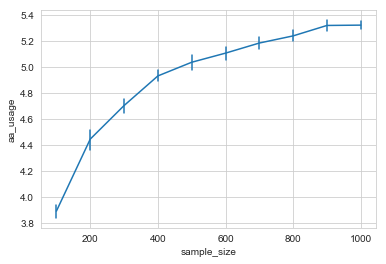

In [283]:
sns.lineplot(x="sample_size", y="aa_usage", data=num_to_aa_usage, err_style="bars")

0.005:
- 100: 3.05 (4.15 for the 100 steps)
- 200: 3.25
- 300: 3.55
- 400: 3.95
- 500: 4.05
- 2000: 4.8
- 3000: 5

0.01:
- 100: 3.9
- 500: 5.1
- 1000: 5.3

0.02:
- 100: 5
- 500: 6.8
- 1000: 7.3

In [40]:
# get S and N for each codon
codon_to_s = {}
for codon in codon_to_aa:
    s = 0
    aa = codon_to_aa[codon]
    codon = list(codon)
    #print(aa, codon)
    
    for pos in range(3):
        for base in ['A', 'C', 'G', 'U']:        
            new_codon = deepcopy(codon)
            if new_codon[pos] == base: continue
            new_codon[pos] = base
            new_aa = codon_to_aa[''.join(new_codon)] 
            if new_aa == "STOP": continue
            if new_aa == aa: s += 1
                
            #print(codon_to_aa[''.join(new_codon)], new_codon)
            
    #print("\n")
    codon_to_s[''.join(codon)] = s/3
print(codon_to_s)

{'UUU': 0.3333333333333333, 'UUC': 0.3333333333333333, 'UUA': 0.6666666666666666, 'UUG': 0.6666666666666666, 'UCU': 1.0, 'UCC': 1.0, 'UCA': 1.0, 'UCG': 1.0, 'UAU': 0.3333333333333333, 'UAC': 0.3333333333333333, 'UAA': 0.0, 'UAG': 0.0, 'UGU': 0.3333333333333333, 'UGC': 0.3333333333333333, 'UGA': 0.0, 'UGG': 0.0, 'CUU': 1.0, 'CUC': 1.0, 'CUA': 1.3333333333333333, 'CUG': 1.3333333333333333, 'CCU': 1.0, 'CCC': 1.0, 'CCA': 1.0, 'CCG': 1.0, 'CAU': 0.3333333333333333, 'CAC': 0.3333333333333333, 'CAA': 0.3333333333333333, 'CAG': 0.3333333333333333, 'CGU': 1.0, 'CGC': 1.0, 'CGA': 1.3333333333333333, 'CGG': 1.3333333333333333, 'AUU': 0.6666666666666666, 'AUC': 0.6666666666666666, 'AUA': 0.6666666666666666, 'AUG': 0.0, 'ACU': 1.0, 'ACC': 1.0, 'ACA': 1.0, 'ACG': 1.0, 'AAU': 0.3333333333333333, 'AAC': 0.3333333333333333, 'AAA': 0.3333333333333333, 'AAG': 0.3333333333333333, 'AGU': 0.3333333333333333, 'AGC': 0.3333333333333333, 'AGA': 0.6666666666666666, 'AGG': 0.6666666666666666, 'GUU': 1.0, 'GUC':

In [217]:
def distance(codon1, codon2):
    codon1 = list(codon1)
    codon2 = list(codon2)
    
    dist = 0
    for i in range(3):
        if codon1[i] != codon2[i]: dist += 1
    return dist

def get_pathway_nd_sd(c1, c2, c3, c4):
    nd = 0
    sd = 0
    if codon_to_aa[''.join(c2)] == "STOP" or codon_to_aa[''.join(c3)] == "STOP":
        return(0, 0)
    if codon_to_aa[''.join(c2)] != codon_to_aa[''.join(c1)]: nd += 1
    else: sd += 1
    if codon_to_aa[''.join(c3)] != codon_to_aa[''.join(c2)]: nd += 1
    else: sd += 1
    if codon_to_aa[''.join(c4)] != codon_to_aa[''.join(c3)]: nd += 1
    else: sd += 1 
        
    return((nd, sd))
    
def get_nd_sd(codon1, codon2):
    dist = distance(codon1, codon2)
    aa1, aa2 = codon_to_aa[codon1], codon_to_aa[codon2]
    c1, c2 = list(codon1), list(codon2)  
    
    # 0 diff
    if dist == 0: return(0, 0)

    # 1 diff
    if dist == 1:
        if aa1 == aa2: return(0,1)  # same aa -- synonymous
        else: return(1,0)  # nonsynonymous
    
    # 2 differences
    if dist == 2:
        nd = 0
        for pos in range(3):
            if c1[pos] == c2[pos]: continue  # not an intermediate
            intermediate = deepcopy(c1)
            intermediate[pos] = c2[pos]
            if codon_to_aa[''.join(intermediate)] == "STOP": continue
            if aa1 != codon_to_aa[''.join(intermediate)]: nd += 0.5
            if codon_to_aa[''.join(intermediate)] != aa2: nd += 0.5
        return(nd, 2 - nd)
                
    # 3 differences
    if dist == 3:
        c10, c11, c12, c20, c21, c22 = c1[0], c1[1], c1[2], c2[0], c2[1], c2[2]
        ndsd = []
        
        ndsd.append(get_pathway_nd_sd(c1, [c20, c11, c12], [c20, c21, c12], c2))
        ndsd.append(get_pathway_nd_sd(c1, [c20, c11, c12], [c20, c11, c22], c2))
        ndsd.append(get_pathway_nd_sd(c1, [c10, c21, c12], [c20, c21, c12], c2))
        ndsd.append(get_pathway_nd_sd(c1, [c10, c21, c12], [c10, c21, c22], c2))
        ndsd.append(get_pathway_nd_sd(c1, [c10, c11, c22], [c20, c11, c22], c2))
        ndsd.append(get_pathway_nd_sd(c1, [c10, c11, c22], [c10, c21, c22], c2))
        
        nd = sum([x[0] for x in ndsd])
        sd = sum([x[1] for x in ndsd])
        total = nd + sd
        return(float(nd * 3/total), float(sd * 3/total))  # to sum to 3

In [416]:
get_nd_sd("UUU", "UUC")

(0, 1)

0.05575710772895841


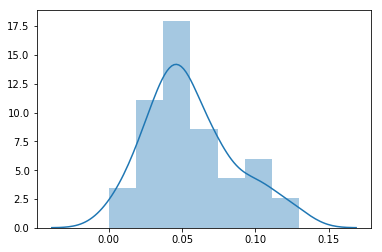

In [230]:
# calculate dN/dS for 1,000 random pairs of proteins
# http://bioinformatics.cvr.ac.uk/blog/calculating-dnds-for-ngs-datasets/
# https://academic.oup.com/mbe/article/3/5/418/988012
initial_seq = seq = ['G', 'C', 'F', 'C', 'M', 'K', 'C', 'G', 'N', 'G', 'C', 'K', 'F', 'K', 'K', 'F', 'K', 'F', 'K', 'W']  # 0.9
seq_mrna = [aa_to_codons[c][0] for c in seq]

dNdS = []
for i in range(1000):
    np.random.seed(i)
    traj1 = final_seqs_mrna[np.random.randint(len(all_trajectories[:1000]))]
    np.random.seed(i*1000)
    traj2 = final_seqs_mrna[np.random.randint(len(all_trajectories[:1000]))]
    #traj2 = seq_mrna
    
    N1 = 0
    S1 = 0
    N2 = 0
    S2 = 0
    Nd = 0
    Sd = 0
    
    for pos in range(20):
        codon1 = traj1[pos]
        codon2 = traj2[pos]
        
        S1 += codon_to_s[codon1]
        S2 += codon_to_s[codon2]
        N1 += (3 - codon_to_s[codon1])
        N2 += (3 - codon_to_s[codon2])
        
        nd, sd = get_nd_sd(codon1, codon2)
        Nd += nd
        Sd += sd
            
    S = float(S1 + S2)/2
    N = float(N1 + N2)/2
    
    pS = Sd/S
    pN = Nd/N
    
    #print(pS, pN)
    if pS >= 0.75 or pN >= 0.75: continue  # this makes the logs not work
        
    dS = -3/4 * np.log(1-4*pS/3)
    dN = -3/4 * np.log(1-4*pN/3)
    if pS < 0.05: continue
    if dS < 0.05: continue  # don't want identical proteins
    dNdS.append(dN/dS)
print(np.mean(dNdS))
sns.distplot(dNdS)

Text(0, 0.5, 'Observed dN/dS')

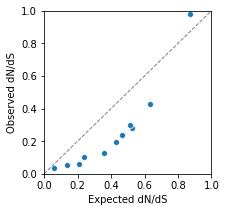

In [231]:
plt.figure(figsize=[3,3])

df_pairwise = pd.DataFrame()
df_pairwise["x"] = [0.061, 0.134, 0.21, 0.24, 0.36, 0.431, 0.468, 0.526, 0.513, 0.632, 0.87]
df_pairwise["y"] = [0.037, 0.056, 0.06, 0.10, 0.13, 0.197, 0.237, 0.283, 0.298, 0.426, 0.98]
df_pairwise["model"] = "epistatic"
g = sns.scatterplot(x="x", 
                    y="y", data=df_pairwise)
plt.xlim([0,1])
plt.ylim([0,1])
g.plot([0,1], [0,1], '--', color="gray", linewidth = 1)
plt.xlabel("Expected dN/dS")
plt.ylabel("Observed dN/dS")

## Evolving proteins using additive models

In [24]:
# from https://github.com/Zsailer/latticeproteins/blob/master/latticeproteins/interactions.py
miyazawa_jernigan = {
'CC':-5.44, 'CM':-5.05, 'CF':-5.63, 'CI':-5.03, 'CL':-5.03, 'CV':-4.46, 'CW':-4.76, 'CY':-3.89, 'CA':-3.38, 'CG':-3.16, 'CT':-2.88, 'CS':-2.86, 'CQ':-2.73, 'CN':-2.59, 'CE':-2.08, 'CD':-2.66, 'CH':-3.63, 'CR':-2.70, 'CK':-1.54, 'CP':-2.92,
'MC':-5.05, 'MM':-6.06, 'MF':-6.68, 'MI':-6.33, 'ML':-6.01, 'MV':-5.52, 'MW':-6.37, 'MY':-4.92, 'MA':-3.99, 'MG':-3.75, 'MT':-3.73, 'MS':-3.55, 'MQ':-3.17, 'MN':-3.50, 'ME':-3.19, 'MD':-2.90, 'MH':-3.31, 'MR':-3.49, 'MK':-3.11, 'MP':-4.11,
'FC':-5.63, 'FM':-6.68, 'FF':-6.85, 'FI':-6.39, 'FL':-6.26, 'FV':-5.75, 'FW':-6.02, 'FY':-4.95, 'FA':-4.36, 'FG':-3.72, 'FT':-3.76, 'FS':-3.56, 'FQ':-3.30, 'FN':-3.55, 'FE':-3.51, 'FD':-3.31, 'FH':-4.61, 'FR':-3.54, 'FK':-2.83, 'FP':-3.73,
'IC':-5.03, 'IM':-6.33, 'IF':-6.39, 'II':-6.22, 'IL':-6.17, 'IV':-5.58, 'IW':-5.64, 'IY':-4.63, 'IA':-4.41, 'IG':-3.65, 'IT':-3.74, 'IS':-3.43, 'IQ':-3.22, 'IN':-2.99, 'IE':-3.23, 'ID':-2.91, 'IH':-3.76, 'IR':-3.33, 'IK':-2.70, 'IP':-3.47,
'LC':-5.03, 'LM':-6.01, 'LF':-6.26, 'LI':-6.17, 'LL':-5.79, 'LV':-5.38, 'LW':-5.50, 'LY':-4.26, 'LA':-3.96, 'LG':-3.43, 'LT':-3.43, 'LS':-3.16, 'LQ':-3.09, 'LN':-2.99, 'LE':-2.91, 'LD':-2.59, 'LH':-3.84, 'LR':-3.15, 'LK':-2.63, 'LP':-3.06,
'VC':-4.46, 'VM':-5.52, 'VF':-5.75, 'VI':-5.58, 'VL':-5.38, 'VV':-4.94, 'VW':-5.05, 'VY':-4.05, 'VA':-3.62, 'VG':-3.06, 'VT':-2.95, 'VS':-2.79, 'VQ':-2.67, 'VN':-2.36, 'VE':-2.56, 'VD':-2.25, 'VH':-3.38, 'VR':-2.78, 'VK':-1.95, 'VP':-2.96,
'WC':-4.76, 'WM':-6.37, 'WF':-6.02, 'WI':-5.64, 'WL':-5.50, 'WV':-5.05, 'WW':-5.42, 'WY':-4.44, 'WA':-3.93, 'WG':-3.37, 'WT':-3.31, 'WS':-2.95, 'WQ':-3.16, 'WN':-3.11, 'WE':-2.94, 'WD':-2.91, 'WH':-4.02, 'WR':-3.56, 'WK':-2.49, 'WP':-3.66,
'YC':-3.89, 'YM':-4.92, 'YF':-4.95, 'YI':-4.63, 'YL':-4.26, 'YV':-4.05, 'YW':-4.44, 'YY':-3.55, 'YA':-2.85, 'YG':-2.50, 'YT':-2.48, 'YS':-2.30, 'YQ':-2.53, 'YN':-2.47, 'YE':-2.42, 'YD':-2.25, 'YH':-3.33, 'YR':-2.75, 'YK':-2.01, 'YP':-2.80,
'AC':-3.38, 'AM':-3.99, 'AF':-4.36, 'AI':-4.41, 'AL':-3.96, 'AV':-3.62, 'AW':-3.93, 'AY':-2.85, 'AA':-2.51, 'AG':-2.15, 'AT':-2.15, 'AS':-1.89, 'AQ':-1.70, 'AN':-1.44, 'AE':-1.51, 'AD':-1.57, 'AH':-2.09, 'AR':-1.50, 'AK':-1.10, 'AP':-1.81,
'GC':-3.16, 'GM':-3.75, 'GF':-3.72, 'GI':-3.65, 'GL':-3.43, 'GV':-3.06, 'GW':-3.37, 'GY':-2.50, 'GA':-2.15, 'GG':-2.17, 'GT':-2.03, 'GS':-1.70, 'GQ':-1.54, 'GN':-1.56, 'GE':-1.22, 'GD':-1.62, 'GH':-1.94, 'GR':-1.68, 'GK':-0.84, 'GP':-1.72,
'TC':-2.88, 'TM':-3.73, 'TF':-3.76, 'TI':-3.74, 'TL':-3.43, 'TV':-2.95, 'TW':-3.31, 'TY':-2.48, 'TA':-2.15, 'TG':-2.03, 'TT':-1.72, 'TS':-1.59, 'TQ':-1.59, 'TN':-1.51, 'TE':-1.45, 'TD':-1.66, 'TH':-2.31, 'TR':-1.97, 'TK':-1.02, 'TP':-1.66,
'SC':-2.86, 'SM':-3.55, 'SF':-3.56, 'SI':-3.43, 'SL':-3.16, 'SV':-2.79, 'SW':-2.95, 'SY':-2.30, 'SA':-1.89, 'SG':-1.70, 'ST':-1.59, 'SS':-1.48, 'SQ':-1.37, 'SN':-1.31, 'SE':-1.48, 'SD':-1.46, 'SH':-1.94, 'SR':-1.22, 'SK':-0.83, 'SP':-1.35,
'QC':-2.73, 'QM':-3.17, 'QF':-3.30, 'QI':-3.22, 'QL':-3.09, 'QV':-2.67, 'QW':-3.16, 'QY':-2.53, 'QA':-1.70, 'QG':-1.54, 'QT':-1.59, 'QS':-1.37, 'QQ':-0.89, 'QN':-1.36, 'QE':-1.33, 'QD':-1.26, 'QH':-1.85, 'QR':-1.85, 'QK':-1.02, 'QP':-1.73,
'NC':-2.59, 'NM':-3.50, 'NF':-3.55, 'NI':-2.99, 'NL':-2.99, 'NV':-2.36, 'NW':-3.11, 'NY':-2.47, 'NA':-1.44, 'NG':-1.56, 'NT':-1.51, 'NS':-1.31, 'NQ':-1.36, 'NN':-1.59, 'NE':-1.43, 'ND':-1.33, 'NH':-2.01, 'NR':-1.41, 'NK':-0.91, 'NP':-1.43,
'EC':-2.08, 'EM':-3.19, 'EF':-3.51, 'EI':-3.23, 'EL':-2.91, 'EV':-2.56, 'EW':-2.94, 'EY':-2.42, 'EA':-1.51, 'EG':-1.22, 'ET':-1.45, 'ES':-1.48, 'EQ':-1.33, 'EN':-1.43, 'EE':-1.18, 'ED':-1.23, 'EH':-2.27, 'ER':-2.07, 'EK':-1.60, 'EP':-1.40,
'DC':-2.66, 'DM':-2.90, 'DF':-3.31, 'DI':-2.91, 'DL':-2.59, 'DV':-2.25, 'DW':-2.91, 'DY':-2.25, 'DA':-1.57, 'DG':-1.62, 'DT':-1.66, 'DS':-1.46, 'DQ':-1.26, 'DN':-1.33, 'DE':-1.23, 'DD':-0.96, 'DH':-2.14, 'DR':-1.98, 'DK':-1.32, 'DP':-1.19,
'HC':-3.63, 'HM':-3.31, 'HF':-4.61, 'HI':-3.76, 'HL':-3.84, 'HV':-3.38, 'HW':-4.02, 'HY':-3.33, 'HA':-2.09, 'HG':-1.94, 'HT':-2.31, 'HS':-1.94, 'HQ':-1.85, 'HN':-2.01, 'HE':-2.27, 'HD':-2.14, 'HH':-2.78, 'HR':-2.12, 'HK':-1.09, 'HP':-2.17,
'RC':-2.70, 'RM':-3.49, 'RF':-3.54, 'RI':-3.33, 'RL':-3.15, 'RV':-2.78, 'RW':-3.56, 'RY':-2.75, 'RA':-1.50, 'RG':-1.68, 'RT':-1.97, 'RS':-1.22, 'RQ':-1.85, 'RN':-1.41, 'RE':-2.07, 'RD':-1.98, 'RH':-2.12, 'RR':-1.39, 'RK':-0.06, 'RP':-1.85,
'KC':-1.54, 'KM':-3.11, 'KF':-2.83, 'KI':-2.70, 'KL':-2.63, 'KV':-1.95, 'KW':-2.49, 'KY':-2.01, 'KA':-1.10, 'KG':-0.84, 'KT':-1.02, 'KS':-0.83, 'KQ':-1.02, 'KN':-0.91, 'KE':-1.60, 'KD':-1.32, 'KH':-1.09, 'KR':-0.06, 'KK':0.13, 'KP':-0.67,
'PC':-2.92, 'PM':-4.11, 'PF':-3.73, 'PI':-3.47, 'PL':-3.06, 'PV':-2.96, 'PW':-3.66, 'PY':-2.80, 'PA':-1.81, 'PG':-1.72, 'PT':-1.66, 'PS':-1.35, 'PQ':-1.73, 'PN':-1.43, 'PE':-1.40, 'PD':-1.19, 'PH':-2.17, 'PR':-1.85, 'PK':-0.67, 'PP':-1.18}

In [25]:
residue_to_mj = defaultdict(lambda: [])
for pair in miyazawa_jernigan:
    residues = list(pair)
    residue_to_mj[residues[0]].append(miyazawa_jernigan[pair])
residue_energy = {aa: np.mean(residue_to_mj[aa]) for aa in residue_to_mj}
print(residue_energy)

{'C': -3.621, 'M': -4.436999999999999, 'F': -4.6155, 'I': -4.341500000000001, 'L': -4.132000000000001, 'V': -3.7030000000000003, 'W': -4.1305, 'Y': -3.2689999999999997, 'A': -2.5960000000000005, 'G': -2.3404999999999996, 'T': -2.347, 'S': -2.1109999999999998, 'Q': -2.068, 'N': -2.0424999999999995, 'E': -2.0505000000000004, 'D': -1.975, 'H': -2.7295, 'R': -2.2199999999999998, 'K': -1.4795, 'P': -2.2435}


In [26]:
def linear_energy(seq):
    return np.sum([residue_energy[aa] for aa in seq])

def linear_fitness(seq):  # we can make this more interesting later
    return linear_energy(seq)

In [27]:
# generate a random sequence
possible_residues = list(residue_energy.keys())
seq = [np.random.choice(possible_residues,1)[0] for i in range(20)]
print(seq)

['Q', 'E', 'T', 'E', 'C', 'V', 'F', 'N', 'L', 'E', 'Y', 'F', 'A', 'Q', 'V', 'W', 'T', 'K', 'C', 'Q']


In [33]:
seq_mrna = [aa_to_codons[c][0] for c in seq]
print(seq_mrna)

['CAA', 'GAA', 'ACU', 'GAA', 'UGU', 'GUU', 'UUU', 'AAU', 'UUA', 'GAA', 'UAU', 'UUU', 'GCU', 'CAA', 'GUU', 'UGG', 'ACU', 'AAA', 'UGU', 'CAA']


In [34]:
fitness = linear_fitness(seq)
fitness

-58.578

In [35]:
def make_mutation_by_purifying_fitness(seq_mrna, fitness, delta=2):
    mutation = [0, ""]

    while True:         
        new_seq_mrna = deepcopy(seq_mrna)
        
        # choose one codon to make the mutation
        pos = np.random.choice(range(len(seq_mrna)))
        new_codon = mutate_codon(seq_mrna[pos])

        old_aa = codon_to_aa[seq_mrna[pos]]
        new_aa = codon_to_aa[new_codon]

        #if new_aa != old_aa:  # nonsynonymous 
            # for adaptive we are allowing synonymous changes
            # for purifying we are allowing synonymous changes
        if new_aa == 'STOP': continue
    
        new_seq_mrna[pos] = new_codon
        new_seq_pro = [codon_to_aa[c] for c in new_seq_mrna]
        new_fitness = linear_fitness(new_seq_pro)

        if np.abs(new_fitness - fitness) < delta:
            mutation = [pos, ''.join([old_aa, new_aa])]
            return((new_seq_mrna, new_fitness, mutation, pos, new_codon)) 
        
def get_trajectory_by_purifying_fitness(seq_mrna, fitness, steps, delta):
    for i in range(steps):
        seq_mrna, new_fitness, mutation, pos, new_codon = make_mutation_by_purifying_fitness(seq_mrna, fitness, delta)
    return seq_mrna

In [170]:
orthologs = []
for i in range(1000):
    if i % 100 == 0:
        print("{}... ".format(i), end="", flush=True)
    orthologs.append(get_trajectory_by_purifying_fitness(seq_mrna, fitness, steps=20, delta=0.28))

0... 100... 200... 300... 400... 500... 600... 700... 800... 900... 

In [171]:
final_seqs = [[codon_to_aa[x] for x in ortholog] for ortholog in orthologs]
aa_usage = [len(np.unique([seq[i] for seq in final_seqs])) for i in range(20)]
print(np.mean(aa_usage))
print((np.mean(aa_usage)-1)/19)

5.8
0.25263157894736843


0.15938529684672892


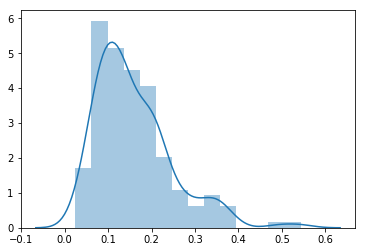

In [172]:
dNdS = []
for i in range(1000):
    np.random.seed(i)
    traj1 = orthologs[np.random.randint(1000)]
    np.random.seed(i*1000)
    traj2 = orthologs[np.random.randint(1000)]
    #traj2 = seq_mrna
    
    N1 = 0
    S1 = 0
    N2 = 0
    S2 = 0
    Nd = 0
    Sd = 0
    
    for pos in range(20):
        codon1 = traj1[pos]
        codon2 = traj2[pos]
        
        S1 += codon_to_s[codon1]
        S2 += codon_to_s[codon2]
        N1 += (3 - codon_to_s[codon1])
        N2 += (3 - codon_to_s[codon2])
        
        nd, sd = get_nd_sd(codon1, codon2)
        Nd += nd
        Sd += sd
            
    S = float(S1 + S2)/2
    N = float(N1 + N2)/2
    
    pS = Sd/S
    pN = Nd/N
    
    #print(pS, pN)
    if pS >= 0.75 or pN >= 0.75: continue  # this makes the logs not work
        
    dS = -3/4 * np.log(1-4*pS/3)
    dN = -3/4 * np.log(1-4*pN/3)
    if pS < 0.05: continue
    if dS < 0.05: continue  # don't want identical proteins
    dNdS.append(dN/dS)
print(np.mean(dNdS))
sns.distplot(dNdS)

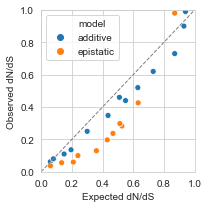

In [501]:
pp = PdfPages("../figures/fig4c.pdf")
plt.figure(figsize=[3,3])
df_additive = pd.DataFrame()
df_additive["x"] = [0.06, 0.08, 0.15, 0.195, 0.30, 0.436, 0.51, 0.55, 0.63, 0.73, 0.87, 0.93, 0.94]
df_additive["y"] = [0.062, 0.08, 0.11, 0.136, 0.25, 0.348, 0.46, 0.44, 0.52, 0.62, 0.73, 0.90, 0.99]
df_additive["model"] = "additive"

df_dnds = pd.concat([df_additive, df_pairwise])
sns.set_style("whitegrid")
g = sns.scatterplot(x="x", y="y", data=df_dnds, hue="model")
plt.xlim([0,1])
plt.ylim([0,1])
g.plot([0,1], [0,1], '--', color="gray", linewidth = 1)
plt.xlabel("Expected dN/dS")
plt.ylabel("Observed dN/dS")
plt.tight_layout()
pp.savefig()
pp.close()